# Retraining MAVE-NN models

In [1]:
import sys
import os
import pickle
import time

from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker

import mavenn

import warnings
warnings.filterwarnings("ignore")

os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/")

First, the SpliMLiB dataset is imported and the header displayed to check formatting and columns names.

In [2]:
with open('splimlib_mave.pickle', 'rb') as f:
    df_sml = pickle.load(f)

In [3]:
df_sml.head()

,mutations,ct_2,ct_1,ct_0,sequences
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV


The column headers are as follows:
- mutation: each variant listing the mutation from WT caMKK1. Note that changes at positions 7a and 8a are listed only if there is an insertion present.
- ct_2: count of sequencing reads in the high gate
- ct_1: sequencing reads in medium gate
- ct_0: sequencing reads in low gate
- sequences: the amino acid resides in the six randomised positions, without intervening constant residues.

The signal from the NGS is normalised to convert into percentage of reads in each of the three NGS gates: these are now listed in columns 'high', 'med' and 'low'.

In [4]:
df_per = df_sml
df_per[['high', 'med', 'low']] = df_sml[['ct_2', 'ct_1', 'ct_0']].div(df_sml[['ct_2', 'ct_1', 'ct_0']].sum(axis=1), axis=0).mul(100).round(3)
df_per.head()

,mutations,ct_2,ct_1,ct_0,sequences,high,med,low
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM,96.814,2.696,0.490
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM,90.390,8.108,1.502
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII,98.900,0.220,0.880
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI,97.596,0.328,2.077
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV,94.218,3.640,2.141


In [5]:
df_sml['stratify'] = 0 # assign everything to group 0 first, just to make sure nothing is without an assignemnt
df_sml.loc[df_sml['high'] > 25, 'stratify'] = 1 # high
df_sml.loc[(df_sml['high'] <= 25) & (df_sml['med'] >=10), 'stratify'] = 2 # mostly high
df_sml.loc[(df_sml['high'] < 1) & (df_sml['med'] < 10), 'stratify'] = 3 # lowest
df_sml.loc[(df_sml['high'] >=1) & (df_sml['high'] <= 25) & (df_sml['med'] < 10), 'stratify'] = 4 # generally low

In [6]:
data_df = df_sml
# Assign to training and test sets
N = len(data_df)
np.random.seed(2000)
r = np.random.rand(N) # get an array of N random numbers between 0 and 1, uniform distribution
data_df['set'] = 'test'

Checking that the final constructed dataset makes sense:

In [11]:
data_df

,mutations,ct_2,ct_1,ct_0,sequences,high,med,low,stratify,set
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM,96.814,2.696,0.490,1,test
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM,90.390,8.108,1.502,1,test
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII,98.900,0.220,0.880,1,test
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI,97.596,0.328,2.077,1,test
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV,94.218,3.640,2.141,1,test
...,...,...,...,...,...,...,...,...,...,...
386026,6P/7aL/9P/11G/13K,0.0,0.0,10.0,PLΔPGK,0.000,0.000,100.000,3,test
386027,6M/7aV/8aA/9Y/11P/13W,0.0,0.0,10.0,MVAYPW,0.000,0.000,100.000,3,test
386028,6L/7aW/9Y/11I/13G,0.0,0.0,10.0,LWΔYIG,0.000,0.000,100.000,3,test
386029,6G/7aP/8aA/9G/11Y/13V,0.0,0.0,10.0,GPAGYV,0.000,0.000,100.000,3,test


This time round, use only top and bottom variants for training.

In [13]:
df_reduced = df_sml.loc[(df_sml['stratify'] == 1) | (df_sml['stratify'] == 3)]

In [14]:
data_df = df_reduced

In [16]:
data_df.describe()

,ct_2,ct_1,ct_0,high,med,low,stratify
count,221277.000000,221277.000000,221277.000000,221277.000000,221277.000000,221277.000000,221277.000000
mean,20.564840,1.843065,17.114761,13.975416,1.965865,84.058719,2.649128
std,59.146463,7.046407,8.410642,31.090571,5.289394,33.514960,0.760681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,12.000000,0.000000,0.000000,95.455000,3.000000
50%,0.000000,0.000000,15.000000,0.000000,0.000000,100.000000,3.000000
75%,0.000000,0.000000,21.000000,0.000000,0.000000,100.000000,3.000000
max,1185.000000,162.000000,95.000000,100.000000,73.684000,100.000000,3.000000


In [18]:
# Assign to training and test sets
N = len(data_df)
np.random.seed(2000)
r = np.random.rand(N) # get an array of N random numbers between 0 and 1, uniform distribution
data_df['set'] = 'test'

test_fractions = {1: 0.4, 3: 0.7 }

for k, v in test_fractions.items():
    test_frac = v # first split of test fraction
    ix_train = (test_frac  <= r) & (data_df['stratify'] == k) 
    ix_test = (r < test_frac) & (data_df['stratify'] == k)
    data_df.loc[ix_train, 'set'] = 'training'
    data_df.loc[ix_test, 'set'] = 'test'

In [19]:
# Split into training and test data
ix = (data_df['set'] == 'training')
train_df = data_df[ix]
test_df = data_df[~ix]

# Extract x and y as np.arrays
x_train = train_df['sequences'].values
y_train = train_df[['high', 'med', 'low']].values
x_test = test_df['sequences'].values
y_test = test_df[['high', 'med', 'low']].values

L = len(data_df['sequences'][0])
y_cols = data_df.columns[5:8]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

# Show dataset sizes
print(f'Training set size: {len(x_train):6,d} observations')
print(f'Test set size    : {len(x_test):6,d} observations')

L=6, Y=3
Training set size: 77,862 observations
Test set size    : 143,415 observations


### Vary the number of hidden nodes

In [20]:
sml_alphabet = np.array(['A','G','P','Y','D','K','M','V','I','L','F','W','Δ'])
wt = 'PΔΔILP'

In [58]:
def train_mave_model(gpmap='additive', 
                     mpa_hidden_nodes=50, 
                     learning_rate=0.005, epochs=50, 
                     batch_size=50, 
                     verbose=False, 
                     stop=True, 
                     lin_init=True):
    # Define model, using default parameters from the package
    model = mavenn.Model(regression_type='MPA',
                         L=L,
                         Y=Y,
                         alphabet=sml_alphabet,
                         gpmap_type= gpmap,
                         mpa_hidden_nodes=mpa_hidden_nodes)

    # Set training data
    model.set_data(x=x_train,
                   y=y_train,
                   shuffle=True,
                   verbose=False)

    # Fit model to data
    model.fit(learning_rate=learning_rate,
              epochs=epochs,
              batch_size=batch_size,
              early_stopping=stop,
              early_stopping_patience=20,
              linear_initialization=lin_init,
              verbose=verbose)

    return model

In [22]:
additive_models = {k: OrderedDict() for k in ['gpmap_tpye', 'mpa_hidden_nodes', 'learning_rate', 'epochs', 'batch_size']}

In [23]:
for n in [10, 20, 40, 80, 100, 120, 150, 200]:
    start_time = time.time()
    model = train_mave_model(gpmap='additive', mpa_hidden_nodes=n)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Hidden nodes: ' + str(n) + f', inference time: {training_time:.2f} seconds')
   
    additive_models['mpa_hidden_nodes'][n] = model

Hidden nodes: 10, inference time: 33.06 seconds
Hidden nodes: 20, inference time: 18.02 seconds
Hidden nodes: 40, inference time: 17.70 seconds
Hidden nodes: 80, inference time: 18.27 seconds
Hidden nodes: 100, inference time: 37.24 seconds
Hidden nodes: 120, inference time: 35.17 seconds
Hidden nodes: 150, inference time: 33.11 seconds
Hidden nodes: 200, inference time: 36.58 seconds


In [24]:
def plot_single_heatmap(model, title, ax, clim=[-4,4]):
    # Get effects of all single-point mutations on phi
    theta_dict = model.get_theta(gauge='user', x_wt=wt)
    # draw heatmap illustrating 1pt mutation effects
    ax, cb = mavenn.heatmap(theta_dict['theta_lc'],
                            alphabet=sml_alphabet,
                            seq=wt,
                            ax=ax,
                            cmap='bwr_r',
                            ccenter=0,
                            cmap_size='2%',
                            clim = clim)
    ax.set_xticklabels(['0','6', '7a', '8a', '9', '11', '13'])
    ax.set_title(title)

    cb.outline.set_visible(False)

In [52]:
def plot_learning_history(model, ax=ax):
    # Get training history
    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']

    # Plot training history as well as information values
    ax.plot(I_var_hist, label='I_var_train')
    ax.plot(val_I_var_hist, label='I_var_val')
    ax.legend()

In [47]:
def plot_loss_history(model, ax):
    # Extract training loss and validation loss
    loss_training = model.history['loss']
    loss_validation = model.history['val_loss']

    # Plot training history as well as information values
    ax.plot(loss_training, color='C2', label='training')
    ax.plot(loss_validation, color='C3', label='validation')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend()

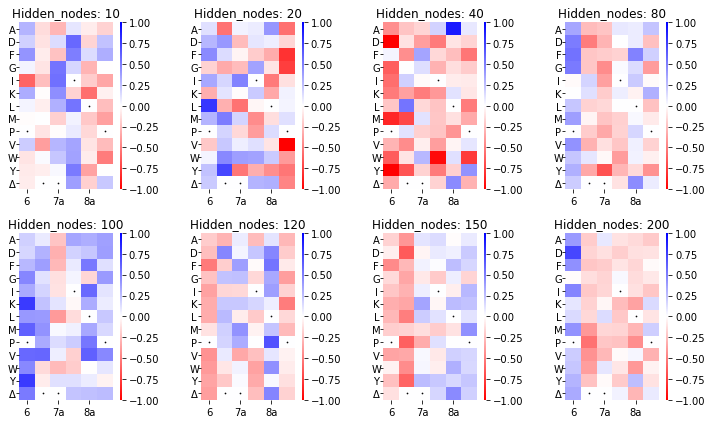

In [25]:
fig, axes = plt.subplots(2,4,figsize=[10,6])

i = 0
for n, model in additive_models['mpa_hidden_nodes'].items():  
    ax = axes.flat[i]
    plot_single_heatmap(model, 'Hidden_nodes: ' + str(n), ax=ax, clim=[-1,1])
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

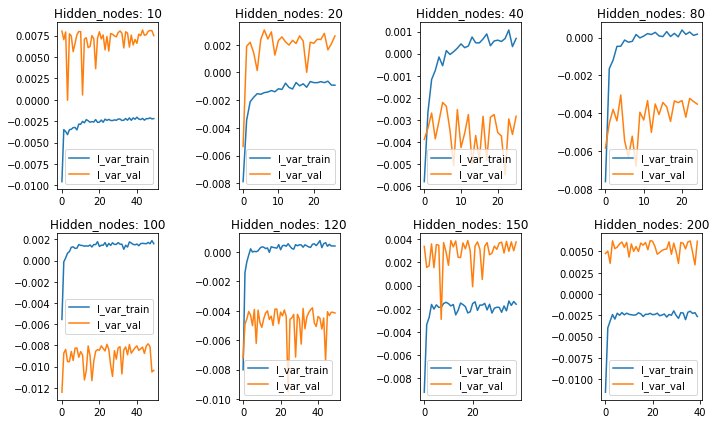

In [27]:
fig, axes = plt.subplots(2,4,figsize=[10,6])

i = 0
for n, model in additive_models['mpa_hidden_nodes'].items():  
    ax = axes.flat[i]
    plot_learning_history(model, 'Hidden_nodes: ' + str(n), ax=ax)
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

None of these models learned anything. The only difference is that a model with more than 50 nodes learns faster.

### Try to re-train the pairwise model in the same fashion

In [28]:
pairwise_models = {k: OrderedDict() for k in ['gpmap_tpye', 'mpa_hidden_nodes', 'learning_rate', 'epochs', 'batch_size']}

In [29]:
for n in [10, 20, 40, 80, 100, 120, 150, 200]:
    start_time = time.time()
    model = train_mave_model(gpmap='pairwise', mpa_hidden_nodes=n, learning_rate=0.005, epochs=50, batch_size=50)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Hidden nodes: ' + str(n) + f', inference time: {training_time:.2f} seconds')
   
    pairwise_models['mpa_hidden_nodes'][n] = model

Hidden nodes: 10, inference time: 39.37 seconds
Hidden nodes: 20, inference time: 40.42 seconds
Hidden nodes: 40, inference time: 39.54 seconds
Hidden nodes: 80, inference time: 42.05 seconds
Hidden nodes: 100, inference time: 40.79 seconds
Hidden nodes: 120, inference time: 42.62 seconds
Hidden nodes: 150, inference time: 44.27 seconds
Hidden nodes: 200, inference time: 43.47 seconds


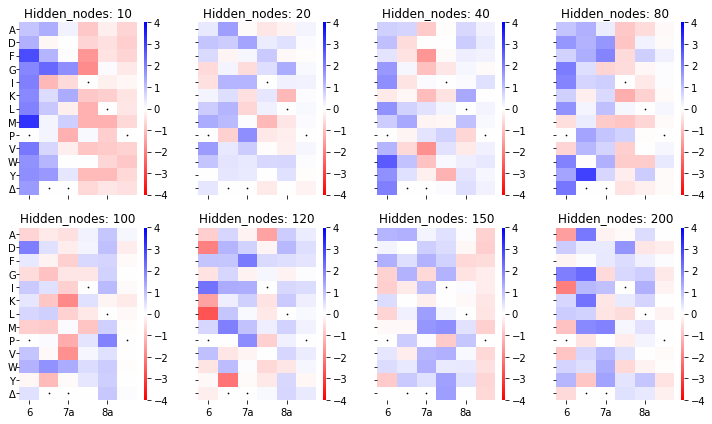

In [34]:
fig, axes = plt.subplots(2,4,sharex=True, sharey=True, figsize=[10,6])

i = 0
for n, model in pairwise_models['mpa_hidden_nodes'].items():  
    ax = axes.flat[i]
    plot_single_heatmap(model, 'Hidden_nodes: ' + str(n), ax=ax)
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

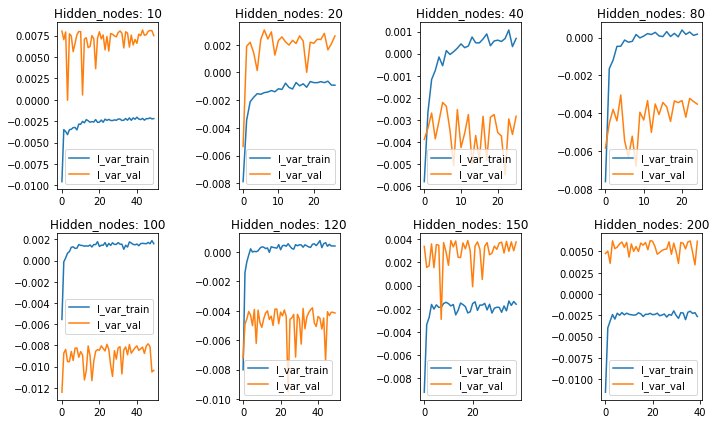

In [35]:
fig, axes = plt.subplots(2,4,figsize=[10,6])

i = 0
for n, model in additive_models['mpa_hidden_nodes'].items():  
    ax = axes.flat[i]
    plot_learning_history(model, 'Hidden_nodes: ' + str(n), ax=ax)
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

Still learning nothing.

### Train again with a longer training process and faster learning rate

In [36]:
pairwise_models = {k: OrderedDict() for k in ['gpmap_tpye', 'mpa_hidden_nodes', 'learning_rate', 'epochs', 'batch_size']}

for n in [10, 30, 50, 100, 150, 200]:
    start_time = time.time()
    model = train_mave_model(gpmap='pairwise', mpa_hidden_nodes=n, learning_rate=0.01, epochs=200, batch_size=300)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Hidden nodes: ' + str(n) + f', inference time: {training_time:.2f} seconds')
   
    pairwise_models['mpa_hidden_nodes'][n] = model

Hidden nodes: 10, inference time: 53.71 seconds
Hidden nodes: 30, inference time: 55.07 seconds
Hidden nodes: 50, inference time: 55.14 seconds
Hidden nodes: 100, inference time: 56.09 seconds
Hidden nodes: 150, inference time: 61.97 seconds
Hidden nodes: 200, inference time: 62.91 seconds


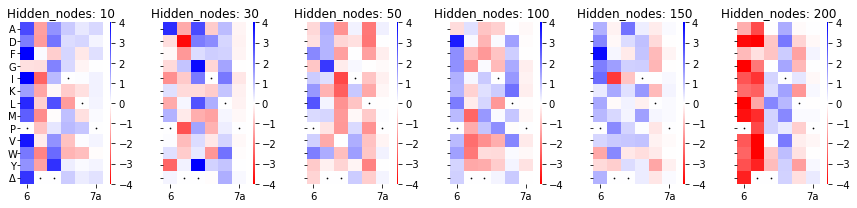

In [37]:
fig, axes = plt.subplots(1,6,sharex=True, sharey=True, figsize=[12,3])

i = 0
for n, model in pairwise_models['mpa_hidden_nodes'].items():  
    ax = axes.flat[i]
    plot_single_heatmap(model, 'Hidden_nodes: ' + str(n), ax=ax)
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

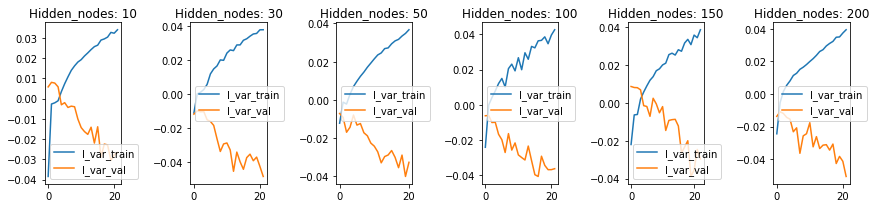

In [38]:
fig, axes = plt.subplots(1,6,figsize=[12,3])

i = 0
for n, model in pairwise_models['mpa_hidden_nodes'].items():  
    ax = axes.flat[i]
    plot_learning_history(model, 'Hidden_nodes: ' + str(n), ax=ax)
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

Still rubbish, tbe extra training epochs were not needed.

### Do again with a slower learning rate

In [ ]:
pairwise_models = {k: OrderedDict() for k in ['gpmap_tpye', 'mpa_hidden_nodes', 'learning_rate', 'epochs', 'batch_size']}

for n in [10, 30, 50, 100, 150, 200]:
    start_time = time.time()
    model = train_mave_model(gpmap='pairwise', mpa_hidden_nodes=n, learning_rate=0.001, epochs=100, batch_size=300)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Hidden nodes: ' + str(n) + f', inference time: {training_time:.2f} seconds')
   
    pairwise_models['mpa_hidden_nodes'][n] = model

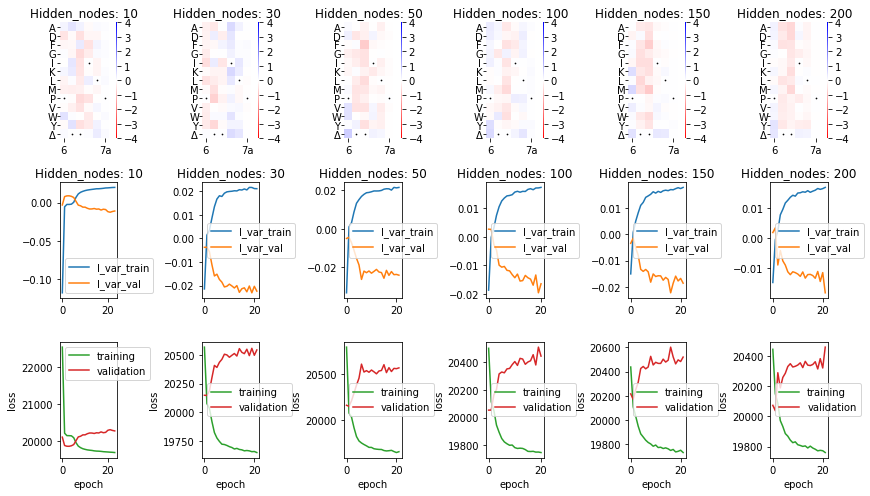

In [50]:
fig, axes = plt.subplots(3,6, figsize=[12,7])

i = 0
for n, model in pairwise_models['mpa_hidden_nodes'].items():  
    plot_single_heatmap(model, 'Hidden_nodes: ' + str(n), ax=axes[0, i])
    plot_learning_history(model, 'Hidden_nodes: ' + str(n), ax=axes[1, i])
    plot_loss_history(model, ax=axes[2, i])
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

### Do it again with different batch sizes

In [40]:
for b in [10, 30, 50, 100, 150, 200]:
    start_time = time.time()
    model = train_mave_model(gpmap='pairwise', mpa_hidden_nodes=50, learning_rate=0.001, epochs=100, batch_size=b)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Batch size: ' + str(b) + f', inference time: {training_time:.2f} seconds')
   
    pairwise_models['batch_size'][b] = model

Batch size: 10, inference time: 370.77 seconds
Batch size: 30, inference time: 167.27 seconds
Batch size: 50, inference time: 119.75 seconds
Batch size: 100, inference time: 83.00 seconds
Batch size: 150, inference time: 71.31 seconds
Batch size: 200, inference time: 60.74 seconds


In [42]:
for b in [300, 400, 500, 1000]:
    start_time = time.time()
    model = train_mave_model(gpmap='pairwise', mpa_hidden_nodes=50, learning_rate=0.001, epochs=100, batch_size=b)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Batch size: ' + str(b) + f', inference time: {training_time:.2f} seconds')
   
    pairwise_models['batch_size'][b] = model

Batch size: 300, inference time: 56.53 seconds
Batch size: 400, inference time: 57.42 seconds
Batch size: 500, inference time: 69.39 seconds
Batch size: 1000, inference time: 73.85 seconds


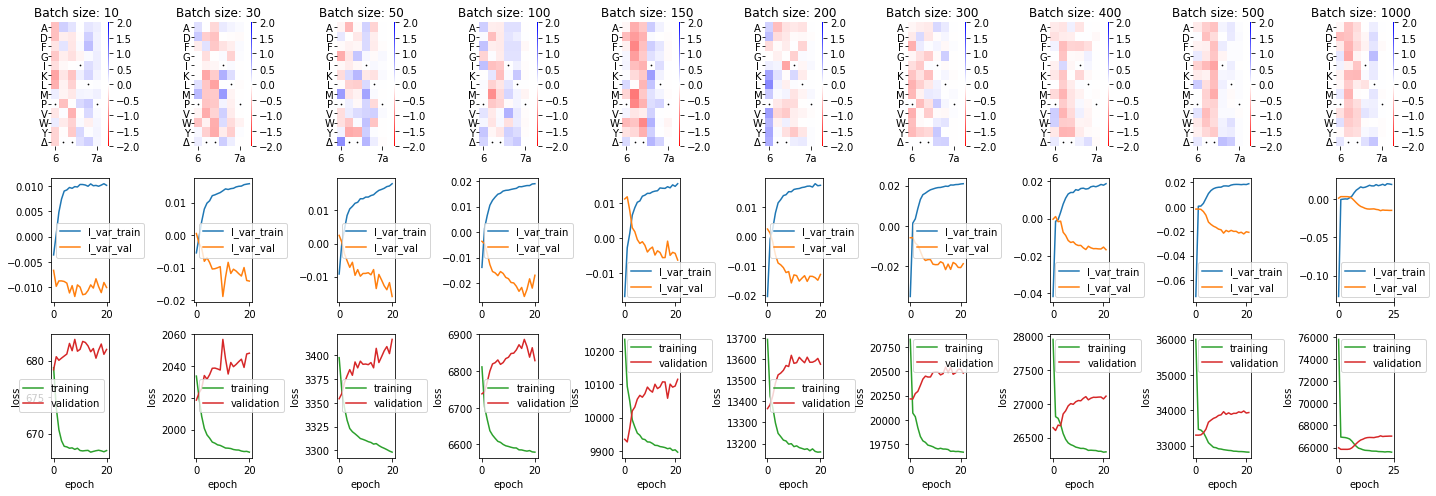

In [56]:
fig, axes = plt.subplots(3,len(pairwise_models['batch_size'].keys()), figsize=[20,7])

i = 0
for b, model in pairwise_models['batch_size'].items():  
    plot_single_heatmap(model, 'Batch size: ' + str(b), ax=axes[0, i], clim=[-2,2])
    plot_learning_history(model, ax=axes[1, i])
    plot_loss_history(model, ax=axes[2, i])
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

None of these have actually learned much and the rate of learning has slowed. They also start performing worse on validation and better on training set during learning.

## Try again without early stopping
Pairwise model, batch size 1000, 200 max epochs, 50-200 hidden nodes

In [59]:
pairwise_models['long_run'] = OrderedDict()

In [62]:
for n in [50, 100, 150, 200]:
    start_time = time.time()
    model = train_mave_model(gpmap='pairwise', mpa_hidden_nodes=n, learning_rate=0.001, epochs=200, batch_size=1000, stop=False, lin_init=True)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Hidden nodes: ' + str(n) + f', inference time: {training_time:.2f} seconds')
   
    pairwise_models['long_run'][n] = model

Hidden nodes: 50, inference time: 62.81 seconds
Hidden nodes: 100, inference time: 73.48 seconds
Hidden nodes: 150, inference time: 72.13 seconds
Hidden nodes: 200, inference time: 72.58 seconds


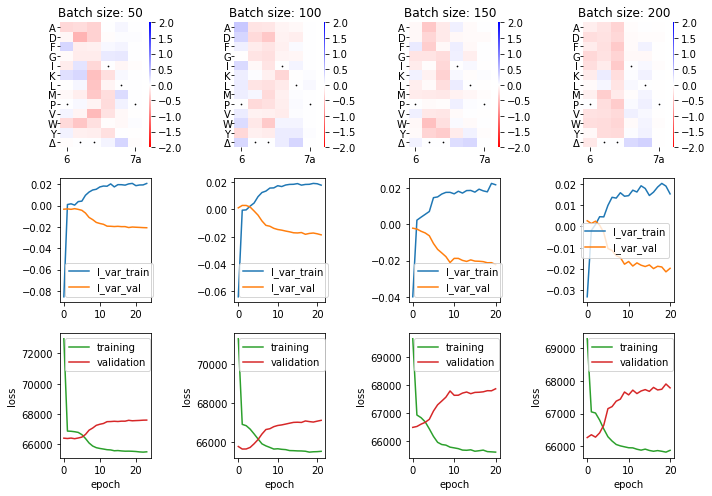

In [63]:
fig, axes = plt.subplots(3,len(pairwise_models['long_run'].keys()), figsize=[10,7])

i = 0
for b, model in pairwise_models['long_run'].items():  
    plot_single_heatmap(model, 'Batch size: ' + str(b), ax=axes[0, i], clim=[-2,2])
    plot_learning_history(model, ax=axes[1, i])
    plot_loss_history(model, ax=axes[2, i])
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

### Non-linear initialisation

In [65]:
pairwise_models['non-linear'] = OrderedDict()

In [66]:
for n in [50, 100, 150, 200]:
    start_time = time.time()
    model = train_mave_model(gpmap='pairwise', mpa_hidden_nodes=n, learning_rate=0.001, epochs=200, batch_size=1000, stop=False, lin_init=False)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Hidden nodes: ' + str(n) + f', inference time: {training_time:.2f} seconds')
   
    pairwise_models['non-linear'][n] = model

Hidden nodes: 50, inference time: 78.69 seconds
Hidden nodes: 100, inference time: 94.46 seconds
Hidden nodes: 150, inference time: 98.42 seconds
Hidden nodes: 200, inference time: 104.82 seconds


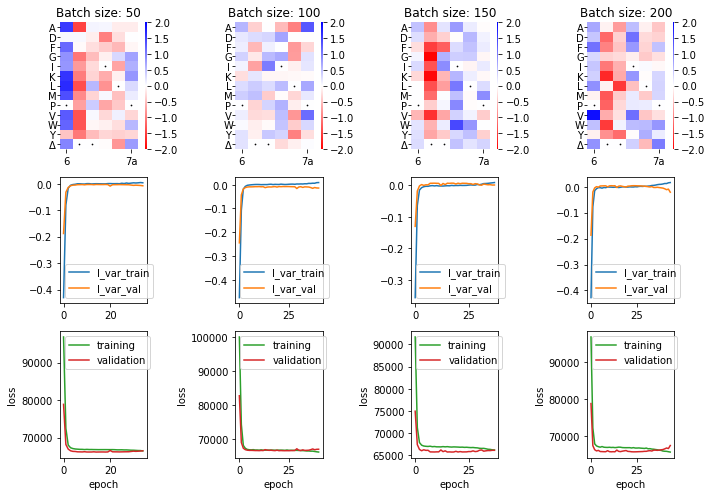

In [67]:
fig, axes = plt.subplots(3,len(pairwise_models['non-linear'].keys()), figsize=[10,7])

i = 0
for b, model in pairwise_models['non-linear'].items():  
    plot_single_heatmap(model, 'Batch size: ' + str(b), ax=axes[0, i], clim=[-2,2])
    plot_learning_history(model, ax=axes[1, i])
    plot_loss_history(model, ax=axes[2, i])
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

### Blackbox model

In [69]:
pairwise_models['blackbox'] = OrderedDict()

for n in [50, 100, 150, 200]:
    start_time = time.time()
    model = train_mave_model(gpmap='blackbox', mpa_hidden_nodes=n, learning_rate=0.001, epochs=200, batch_size=1000, stop=False)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Hidden nodes: ' + str(n) + f', inference time: {training_time:.2f} seconds')
   
    pairwise_models['blackbox'][n] = model

Hidden nodes: 50, inference time: 18.00 seconds
Hidden nodes: 100, inference time: 19.45 seconds
Hidden nodes: 150, inference time: 18.81 seconds
Hidden nodes: 200, inference time: 20.93 seconds


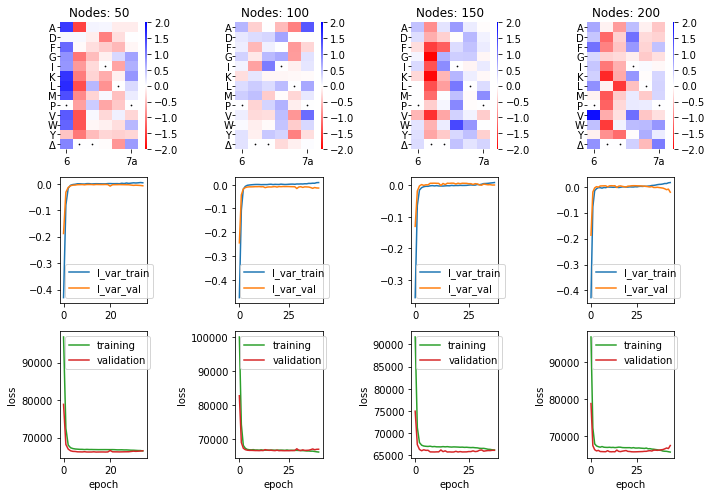

In [70]:
fig, axes = plt.subplots(3,len(pairwise_models['blackbox'].keys()), figsize=[10,7])

i = 0
for n, model in pairwise_models['non-linear'].items():  
    plot_single_heatmap(model, 'Nodes: ' + str(n), ax=axes[0, i], clim=[-2,2])
    plot_learning_history(model, ax=axes[1, i])
    plot_loss_history(model, ax=axes[2, i])
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

In [78]:
blackbox_models = {k: OrderedDict() for k in ['gpmap_tpye', 'mpa_hidden_nodes', 'learning_rate', 'epochs', 'batch_size']}

In [79]:
for r in [0.01,0.005, 0.001, 0.0001]:
    start_time = time.time()
    model = train_mave_model(gpmap='blackbox', mpa_hidden_nodes=100, learning_rate= r, epochs=200, batch_size=1000, stop=False)
    
    # Report fitting time
    training_time = time.time()-start_time
    print('Hidden nodes: ' + str(r) + f', inference time: {training_time:.2f} seconds')
   
    blackbox_models['learning_rate'][r] = model

Hidden nodes: 0.01, inference time: 14.92 seconds
Hidden nodes: 0.005, inference time: 16.89 seconds
Hidden nodes: 0.001, inference time: 20.22 seconds
Hidden nodes: 0.0001, inference time: 52.11 seconds


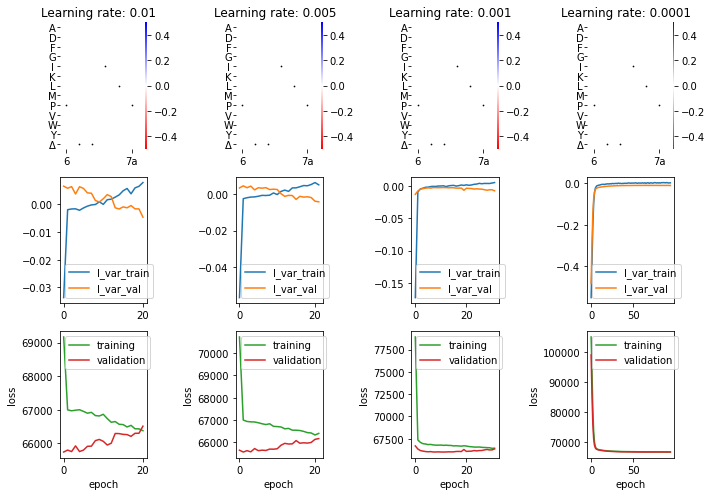

In [81]:
fig, axes = plt.subplots(3,len(blackbox_models['learning_rate'].keys()), figsize=[10,7])

i = 0
for r, model in blackbox_models['learning_rate'].items():  
    plot_single_heatmap(model, 'Learning rate: ' + str(r), ax=axes[0, i], clim=[-0.5,0.5])
    plot_learning_history(model, ax=axes[1, i])
    plot_loss_history(model, ax=axes[2, i])
    i += 1

fig.tight_layout(w_pad=3)
plt.show()

Blackbox models aren't really any better.